# Anomaly Detection
### Use case: Arrhythmia detection
**Paper**: [Anomaly Detection in Time Series: A Comprehensive Evaluation](https://www.vldb.org/pvldb/vol15/p1779-wenig.pdf)   
**Data**: [SVDB](https://hpi-information-systems.github.io/timeeval-evaluation-paper/notebooks/Datasets.html)  
**Code**: [Unit8 post](https://unit8.com/resources/anomaly-detection-in-healthcare-data-with-darts/)   

Nov 4th 2023

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.utils.statistics import plot_acf
from darts.metrics import mae, rmse, mape
from darts.models import LinearRegressionModel
from darts.ad.scorers import NormScorer, KMeansScorer
from darts.ad.anomaly_model.forecasting_am import ForecastingAnomalyModel

In [11]:
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plotsize = (22, 10)
plt.rcParams['figure.figsize']= plotsize
# Pandas config
pd.options.display.float_format= '{:,.4f}'.format

## 1) Input data

In [4]:
CSV_PATH = "./multivariate/SVDB/842.test.csv"
df = pd.read_csv(CSV_PATH)
df

,timestamp,ECG1,ECG2,is_anomaly
0,1970-01-01 00:00:00.000000000,-0.3200,0.0750,0
1,1970-01-01 00:00:00.007812500,-0.3350,0.0450,0
2,1970-01-01 00:00:00.015625000,-0.3550,0.0500,0
3,1970-01-01 00:00:00.023437500,-0.3050,0.0150,0
4,1970-01-01 00:00:00.031250000,-0.2800,0.0100,0
...,...,...,...,...
230395,1970-01-01 00:29:59.960937500,-0.1650,0.0000,0
230396,1970-01-01 00:29:59.968750000,-0.1450,-0.0050,0
230397,1970-01-01 00:29:59.976562500,-0.1400,0.0150,0
230398,1970-01-01 00:29:59.984375000,-0.1350,0.0100,0


In [6]:
timeseries = TimeSeries.from_csv(CSV_PATH, time_col="timestamp")
ts_ecg = timeseries[["ECG1", "ECG2"]]
ts_anomaly = timeseries[["is_anomaly"]]

Becase we have a lot of data, we are going to specify a smaller time frame for better interpretability.

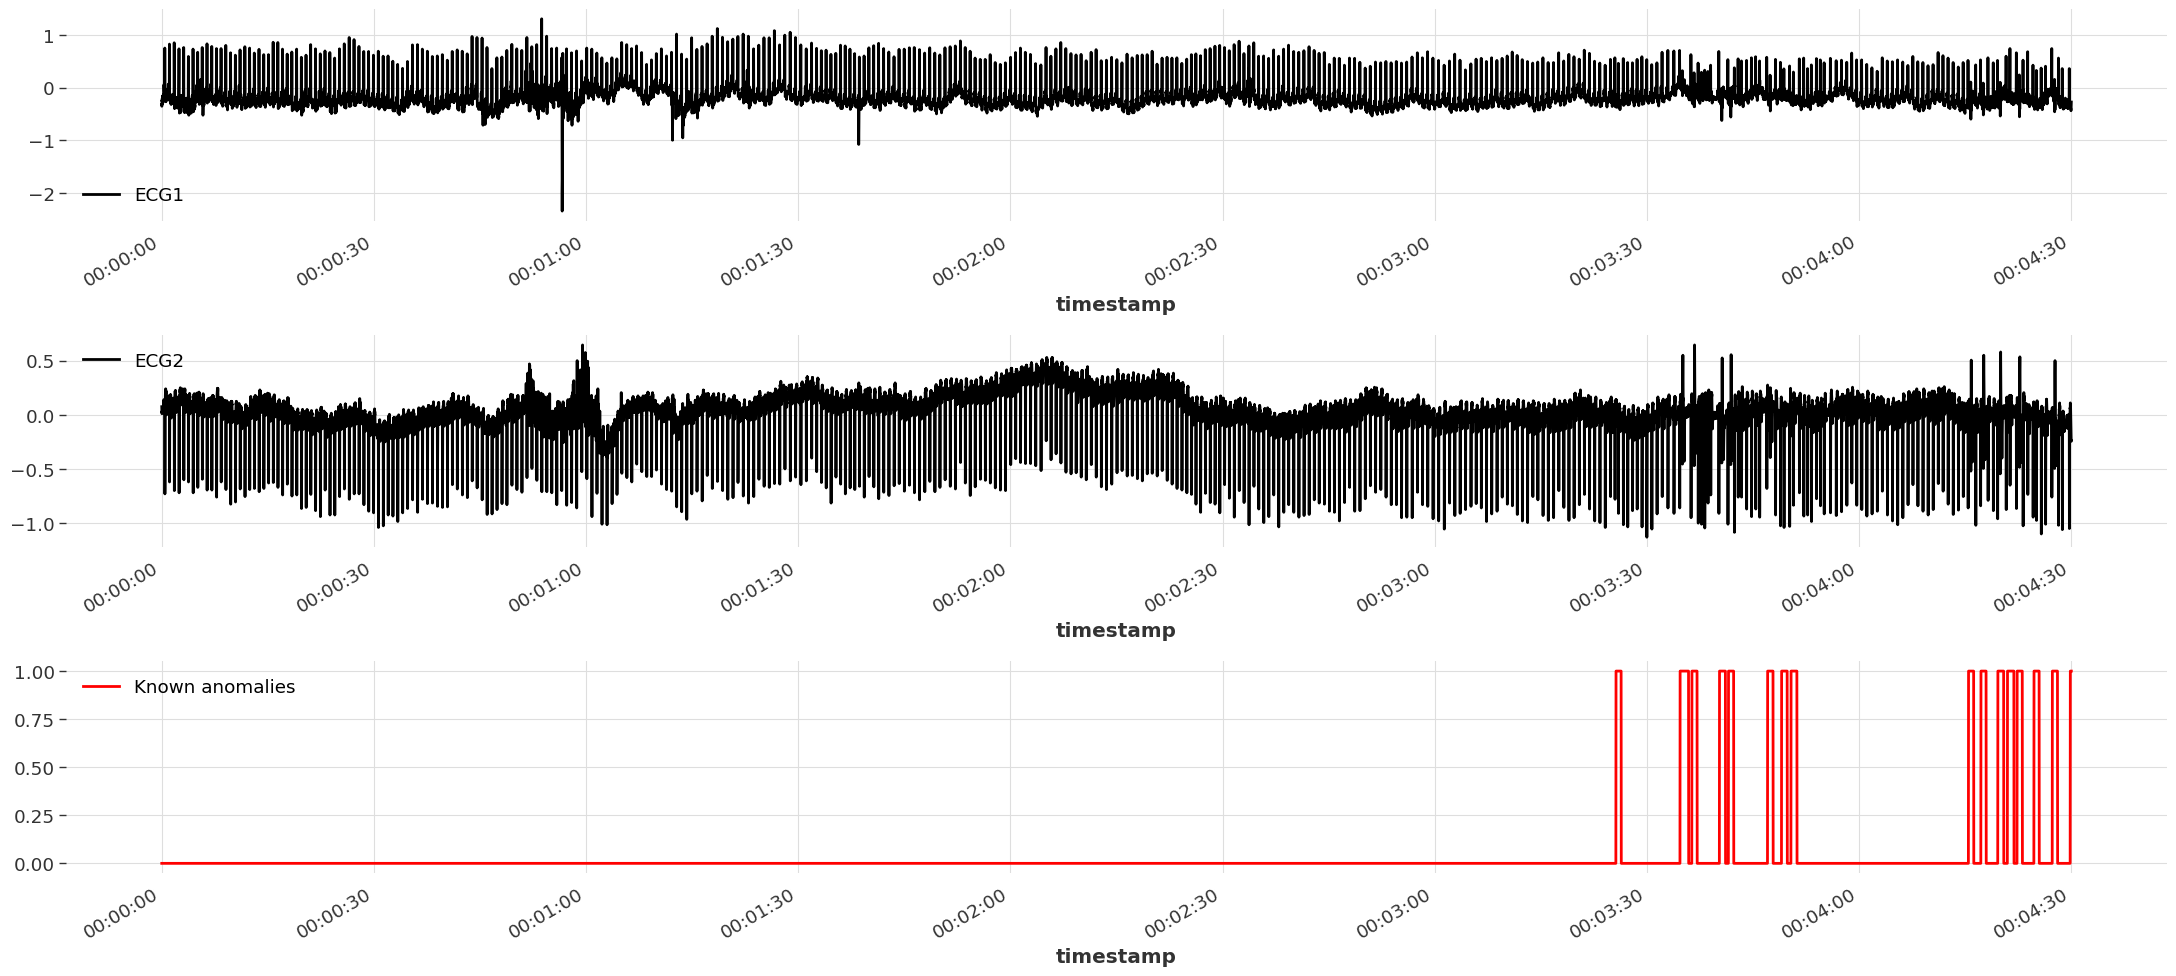

In [16]:
CUTOFF = 34560
end = ts_ecg.get_timestamp_at_point(CUTOFF) # 34560 points which corresponds to 4.5 min at 128Hz
fig, axes = plt.subplots(3,1)

ts_ecg["ECG1"][:end].plot(ax=axes[0])
ts_ecg["ECG2"][:end].plot(ax=axes[1])
ts_anomaly[:end].plot(ax=axes[2], label="Known anomalies", color="r")

plt.tight_layout()

## 2) Train/Test

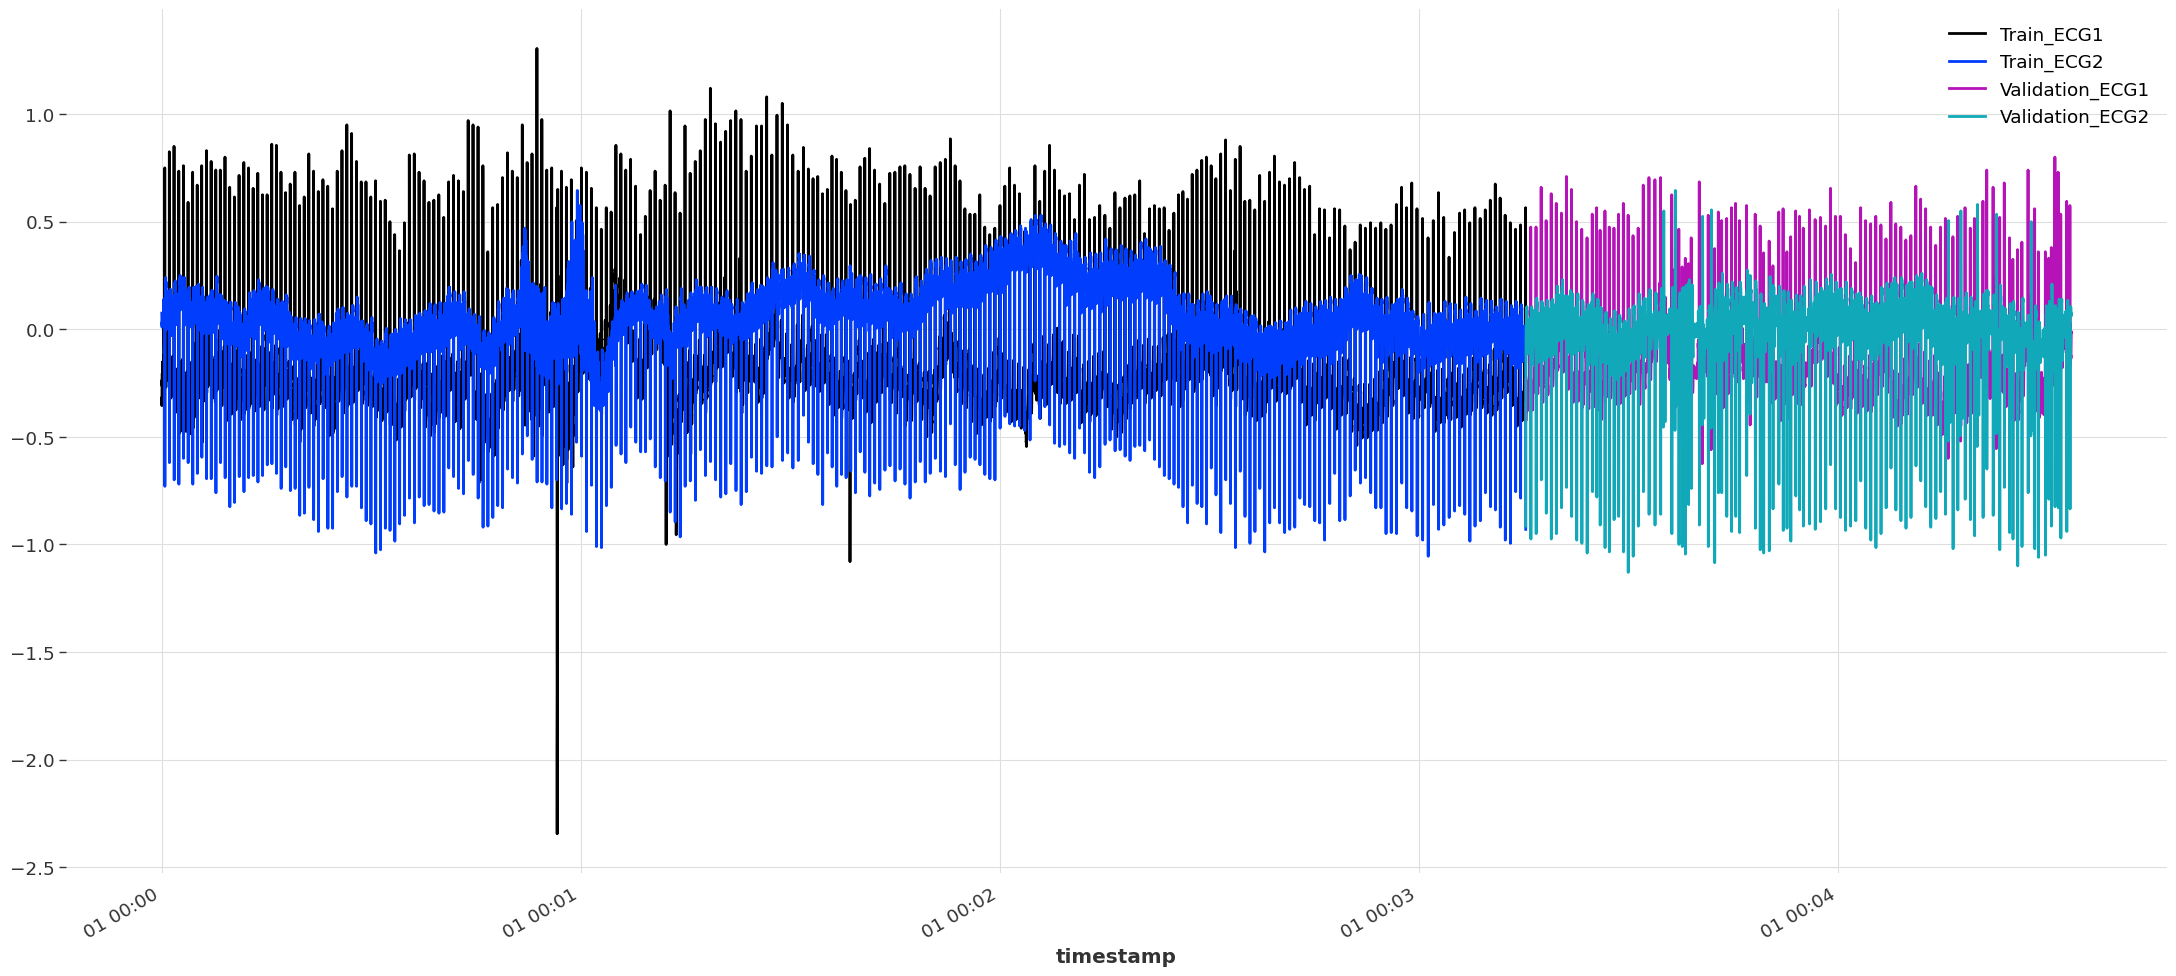

In [23]:
TRAIN_CUTOFF = 25000
TEST_CUTOFF = 35000
# Train
ts_ecg_train = ts_ecg[:TRAIN_CUTOFF]
ts_ecg_test = ts_ecg[TRAIN_CUTOFF:TEST_CUTOFF]
ts_anomaly_test = ts_anomaly[TRAIN_CUTOFF:TEST_CUTOFF]

ts_ecg_train.plot(label="Train")
ts_ecg_test.plot(label="Validation")
plt.tight_layout()

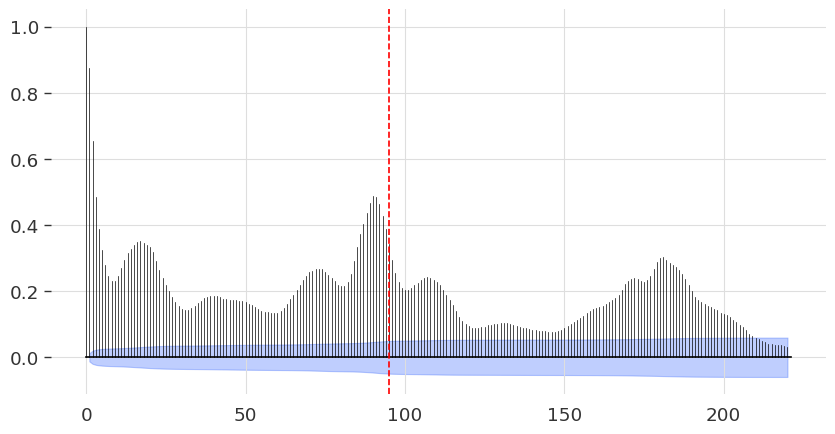

In [31]:
period = 95
plot_acf(ts=ts_ecg_train['ECG1'], max_lag=220)
plt.axvline(x=period, color="red", linestyle="dashed")
plt.show()

## 3) Anomaly Detection

In [34]:
forecasting_model = LinearRegressionModel(lags=period)
anomaly_model = ForecastingAnomalyModel(
    model=forecasting_model,
    scorer=[
        NormScorer(ord=1),
        KMeansScorer(k=50, window=2*period, component_wise=False)
    ],
)
# Fit the anomaly model
START = 2 * period
anomaly_model.fit(ts_ecg_train, start=START, allow_model_training=True)

/Users/razielar/miniconda3/envs/darts/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [40]:
# Score with the anomaly model (forecasting + scoring)
anomaly_scores, model_forecasting = anomaly_model.score(
    ts_ecg_test, start=2*period, return_model_prediction=True
)
print(f"On testing set -> MAE: {mae(model_forecasting, ts_ecg_test): .4f}, RMSE: {rmse(model_forecasting, ts_ecg_test)}, MAPE: {mape(model_forecasting, ts_ecg_test): .2f}")

On testing set -> MAE:  0.0345, RMSE: 0.053121543072390004, MAPE:  140.66


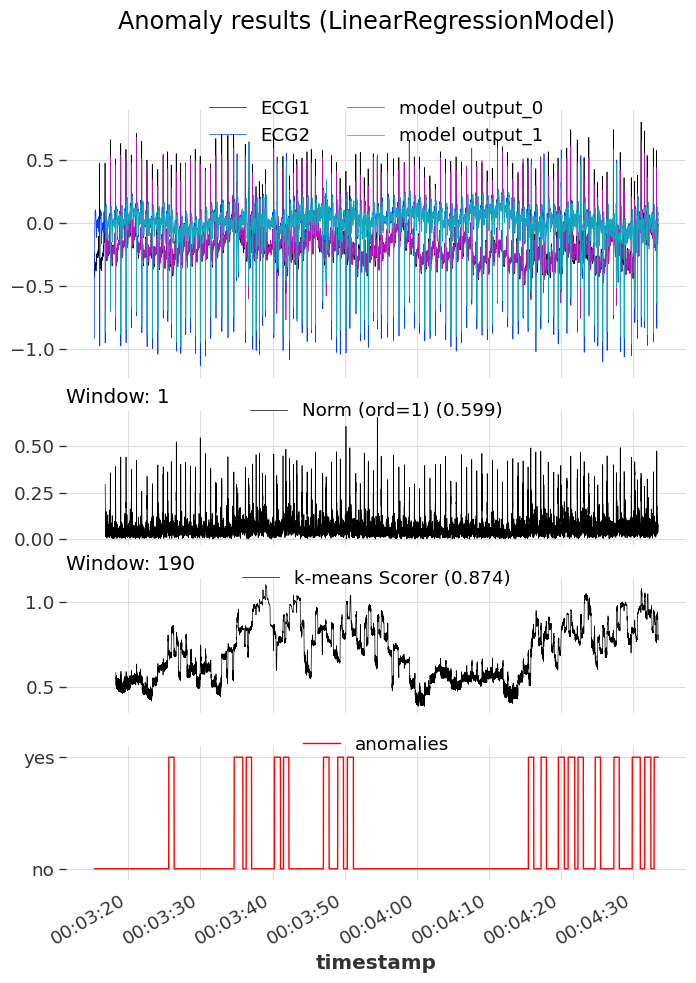

In [42]:
# Visualize anomalies
anomaly_model.show_anomalies(
    series=ts_ecg_test,
    actual_anomalies=ts_anomaly_test,
    start=START,
    metric="AUC_ROC",
)